# Building a Coalescent Model with State Indexing

This tutorial demonstrates how to use the flexible state indexing system in `phasic.state_indexing` to construct a coalescent model with population structure.

## Overview

The state indexing system provides a dynamic way to convert between:
- **Linear indices** (used internally by graph vertices)
- **Property dictionaries** (human-readable state descriptions)

This is particularly useful for complex models where state space is defined by multiple properties (e.g., number of lineages in different populations).

In [1]:
import phasic # ALWAYS import phasic first
from phasic.state_indexing import Property, StateSpace, StateVector
import numpy as np
from phasic import Graph
import matplotlib.pyplot as plt

## Example 1: Simple Coalescent (Single Population)

Let's start with the simplest coalescent model: a single panmictic population.

### Define the State Space

In a basic coalescent model, the only property is the number of lineages (descendants).

In [2]:
# Define state space for 5 samples
n_samples = 5

# Create a single property: number of descendants (lineages)
# min_value=1 because we need at least 1 lineage (until coalescence completes)
state_space = StateSpace([
    Property('n_lineages', max_value=n_samples, min_value=1)
])

print(f"State space size: {state_space.size}")
print(f"This includes index 0 (starting vertex) + {state_space.size - 1} property combinations")

State space size: 6
This includes index 0 (starting vertex) + 5 property combinations


### Explore Index ↔ Properties Conversion

In [3]:
# Index 0 is reserved for starting vertex
print("Index 0 (starting vertex):", state_space.index_to_props(0))
print()

# Indices 1+ represent property combinations
for i in range(1, state_space.size):
    props = state_space.index_to_props(i)
    print(f"Index {i}: {props['n_lineages']} lineage(s)")
    
    # Verify round-trip conversion
    idx = state_space.props_to_index(props)
    assert idx == i, f"Round-trip failed: {i} -> {props} -> {idx}"

Index 0 (starting vertex): None

Index 1: 1 lineage(s)
Index 2: 2 lineage(s)
Index 3: 3 lineage(s)
Index 4: 4 lineage(s)
Index 5: 5 lineage(s)


### Build a Coalescent Graph Using State Indexing

Now let's use the state space to build a proper coalescent graph where vertex indices correspond to meaningful states.

In [4]:
def coalescent_callback_indexed(state, state_space, theta=1.0):
    """
    Coalescent callback using state indexing.
    
    Parameters
    ----------
    state : np.ndarray
        Current state array [vertex_index]
    state_space : StateSpace
        State space defining the model
    theta : float
        Population-scaled mutation rate (4*Ne*mu)
    """
    vertex_idx = int(state[0])
    
    # Index 0 is the starting vertex - transition to initial state
    if vertex_idx == 0:
        # Start with n_samples lineages
        initial_idx = state_space.props_to_index({'n_lineages': n_samples})
        return [(np.array([initial_idx]), 1.0, [1.0])]
    
    # Get properties for current state
    props = state_space.index_to_props(vertex_idx)
    n = props['n_lineages']
    
    # Absorbing state (MRCA reached)
    if n == 1:
        return []
    
    # Coalescent rate: n*(n-1)/2 per unit time
    # With theta parameterization: rate = n*(n-1)/theta
    coalescent_rate = n * (n - 1) / 2.0
    
    # Transition to n-1 lineages
    next_props = {'n_lineages': n - 1}
    next_idx = state_space.props_to_index(next_props)
    
    # Return: (next_state, base_weight, [coefficients])
    # Parameterized edge: weight = coalescent_rate * theta[0]
    return [(np.array([next_idx]), 0.0, [coalescent_rate])]

# Build the graph
graph = Graph(
    state_length=1,  # State is just the vertex index
    callback=lambda state: coalescent_callback_indexed(state, state_space),
    parameterized=True
)

print(f"Graph vertices: {graph.vertices_length()}")
print(f"Graph edges: {graph.edges_length()}")

ValueError: First argument must be either an integer state length or a callback function

### Visualize and Analyze

In [5]:
# Plot the graph structure
# graph.plot(max_nodes=20)

# Compute coalescent times
theta = 1.0
times = np.linspace(0.1, 5.0, 100)

# Get state probabilities over time
state_probs = graph.state_probability(times, theta=np.array([theta]))

# Plot probability of being in each state
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(1, state_space.size):
    props = state_space.index_to_props(i)
    n = props['n_lineages']
    ax.plot(times, state_probs[:, i], label=f"{n} lineage(s)")

ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.set_title(f'Coalescent Process (n={n_samples}, θ={theta})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'graph' is not defined

## Example 2: Two-Population Coalescent

Now let's build a more complex model with population structure.

### Define State Space with Two Populations

In [6]:
# Two populations, 3 samples each
n1 = 3  # Samples from population 1
n2 = 3  # Samples from population 2

# State space: (lineages in pop 1, lineages in pop 2)
two_pop_space = StateSpace([
    Property('n_pop1', max_value=n1, min_value=0),
    Property('n_pop2', max_value=n2, min_value=0)
])

print(f"State space size: {two_pop_space.size}")
print(f"Property combinations: {two_pop_space.size - 1}")

# Show some example states
print("\nExample states:")
for i in [1, 5, 10, 15]:
    if i < two_pop_space.size:
        props = two_pop_space.index_to_props(i)
        print(f"Index {i:2d}: {props['n_pop1']} in pop1, {props['n_pop2']} in pop2")

State space size: 17
Property combinations: 16

Example states:
Index  1: 0 in pop1, 0 in pop2
Index  5: 0 in pop1, 1 in pop2
Index 10: 1 in pop1, 2 in pop2
Index 15: 2 in pop1, 3 in pop2


### Demonstrate Array-Based Operations

The state indexing system supports vectorized operations for efficiency.

In [7]:
# Convert multiple indices at once
indices = np.array([1, 5, 10, 15])
props_list = two_pop_space.index_to_props(indices)

print("Vectorized index_to_props:")
for i, props in zip(indices, props_list):
    if props is not None:
        print(f"Index {i:2d}: {props}")

# Alternative: get as array instead of dict
print("\nAs arrays (n_pop1, n_pop2):")
props_array = two_pop_space.index_to_props(indices, as_dict=False)
print(props_array)

Vectorized index_to_props:
Index  1: {'n_pop1': 0, 'n_pop2': 0}
Index  5: {'n_pop1': 0, 'n_pop2': 1}
Index 10: {'n_pop1': 1, 'n_pop2': 2}
Index 15: {'n_pop1': 2, 'n_pop2': 3}

As arrays (n_pop1, n_pop2):
[[0 0]
 [0 1]
 [1 2]
 [2 3]]


### Build Two-Population Coalescent with Migration

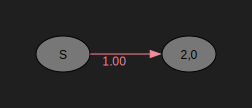

In [14]:
def two_pop_coalescent_callback(state, state_space=None, theta1=1.0, theta2=1.0, mig_rate=0.1):
    """
    Two-population coalescent with migration.
    
    Parameters
    ----------
    state : np.ndarray
        [vertex_index]
    state_space : StateSpace
        State space with 'n_pop1' and 'n_pop2' properties
    theta1, theta2 : float
        Population-scaled mutation rates (4*Ne*mu) for each population
    mig_rate : float
        Migration rate between populations
    """
    vertex_idx = int(state[0])
    
    # Starting vertex
    if vertex_idx == 0:
        initial_idx = state_space.props_to_index({'n_pop1': n1, 'n_pop2': n2})
        return [(np.array([initial_idx]), 1.0, [1.0])]
    
    props = state_space.index_to_props(vertex_idx)
    n_p1 = props['n_pop1']
    n_p2 = props['n_pop2']
    
    # Absorbing state (all lineages coalesced)
    total = n_p1 + n_p2
    if total <= 1:
        return []
    
    transitions = []
    
    # Coalescence in population 1
    if n_p1 >= 2:
        rate = n_p1 * (n_p1 - 1) / 2.0
        next_idx = state_space.props_to_index({'n_pop1': n_p1 - 1, 'n_pop2': n_p2})
        transitions.append((np.array([next_idx]), 0.0, [rate]))
    
    # Coalescence in population 2
    if n_p2 >= 2:
        rate = n_p2 * (n_p2 - 1) / 2.0
        next_idx = state_space.props_to_index({'n_pop1': n_p1, 'n_pop2': n_p2 - 1})
        transitions.append((np.array([next_idx]), 0.0, [rate]))
    
    # Migration: pop1 -> pop2
    if n_p1 >= 1 and n_p2 < n2:
        rate = n_p1 * mig_rate
        next_idx = state_space.props_to_index({'n_pop1': n_p1 - 1, 'n_pop2': n_p2 + 1})
        transitions.append((np.array([next_idx]), 0.0, [rate]))
    
    # Migration: pop2 -> pop1
    if n_p2 >= 1 and n_p1 < n1:
        rate = n_p2 * mig_rate
        next_idx = state_space.props_to_index({'n_pop1': n_p1 + 1, 'n_pop2': n_p2 - 1})
        transitions.append((np.array([next_idx]), 0.0, [rate]))
    
    return transitions

# Build the graph
two_pop_graph = Graph(two_pop_coalescent_callback, 
                      ipv=[2, 0],
                      state_space=two_pop_space)
two_pop_graph.plot()

### Analyze State Space Structure

In [ ]:
# Create a matrix showing which states exist
state_matrix = np.zeros((n1 + 1, n2 + 1), dtype=int)

for i in range(1, two_pop_space.size):
    props = two_pop_space.index_to_props(i)
    state_matrix[props['n_pop1'], props['n_pop2']] = i

# Visualize state space
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(state_matrix, cmap='viridis', origin='lower')

# Add index labels
for i in range(n1 + 1):
    for j in range(n2 + 1):
        if state_matrix[i, j] > 0:
            ax.text(j, i, str(state_matrix[i, j]), 
                   ha='center', va='center', color='white', fontweight='bold')

ax.set_xlabel('Lineages in Population 2')
ax.set_ylabel('Lineages in Population 1')
ax.set_title('State Space: Vertex Index by Population Configuration')
ax.set_xticks(range(n2 + 1))
ax.set_yticks(range(n1 + 1))
plt.colorbar(im, ax=ax, label='Vertex Index')
plt.tight_layout()
plt.show()

## Example 3: Using StateVector for Interactive State Manipulation

In [ ]:
# StateVector provides a dict-like interface with validation
state = StateVector(two_pop_space, props={'n_pop1': 2, 'n_pop2': 3})

print(f"Initial state: {state}")
print(f"Index: {state.index}")
print(f"Pop1 lineages: {state['n_pop1']}")
print(f"Pop2 lineages: {state['n_pop2']}")

# Modify a property
state['n_pop1'] = 1
state.update_index()  # Sync the index

print(f"\nAfter coalescence in pop1: {state}")
print(f"New index: {state.index}")

# Validation prevents invalid states
try:
    state['n_pop1'] = 10  # Exceeds max_value
except ValueError as e:
    print(f"\nValidation error (expected): {e}")

## Summary

The state indexing system provides:

1. **Flexible state representation**: Define arbitrary combinations of properties
2. **Automatic index management**: Convert between human-readable properties and graph indices
3. **Validation**: Ensure property values stay within valid ranges
4. **Backward compatibility**: The `offset` parameter is deprecated but still works
5. **Reserved index 0**: Starting vertex has special meaning (returns `None`)

### Key Classes

- **`Property`**: Defines a single state dimension (name, min_value, max_value)
- **`StateSpace`**: Manages collections of properties and conversions
- **`StateVector`**: Dict-like interface with validation

### Best Practices

1. Use `min_value` instead of the deprecated `offset` parameter
2. Remember index 0 is reserved (check for `None` when converting)
3. Use `as_dict=False` for efficient array operations
4. Validate your state space size matches expected graph vertices

### Next Steps

- Extend to more complex models (multi-locus, selection, recombination)
- Integrate with trace-based elimination for efficient computation
- Use with SVGD for parameter inference